In [1]:
import torch

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:



import numpy as np
#import deepchem as dc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import torch
from pysmiles import read_smiles
import networkx as nx
import dgllife
from rdkit import Chem
import random
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import dgl
from dgl import DGLGraph
from torch.nn.utils.rnn import pad_sequence



import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from torch.distributions import Categorical
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

Using backend: pytorch[09:53:00] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.9.1.so: cannot open shared object file: No such file or directory



In [1]:
class GraphGenEnv(object):
    '''
    Class which holds logic for graph generation environment 
    Observations come in the form of (current_graph, last action was node addition, last node features)
    
    
    '''
    def __init__(self, max_nodes, num_atom_types, num_node_feats, num_edge_types, bond_padding, RewardModule):
        '''
        ENV_Atoms
        '''
        print('correct env')
        self.atom_list = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K', 'Aro']
        self.atom_bond_dict = {'N':[1,0,5], 'C':[2,0,4], 'O':[3,0,6], 'S':[4,0,6],
                               'F':[5,0,7], 'Cl' : [6,0,7],'Na':[7,0,7], 'P' : [8,0,5],
                               'Br':[9,0,7], 'Si' : [10,0,4],'B':[11,0,5], 'Se' : [12,0,6],
                               'K':[13,0,7]}
        
        '''
        ENV_Attributes
        '''
        self.max_nodes = max_nodes
        self.bond_padding = bond_padding 
        self.num_atom_types = self.atom_list.__len__()
        self.batch_dim = 1
        
        
        self.stateSpaceGraph = dgl.graph(([], [])).to(device)
        self.stateSpaceGraph.ndata['atomic'] = torch.zeros(0, num_node_feats).to(device)
        self.stateSpaceGraph.edata['type'] = torch.zeros(0,1).to(device)
        
        
        
        '''ENV_State'''
        self.Done = False
        self.last_action_node = torch.zeros((1,1)).to(device)
        self.num_node_feats = num_node_feats
        self.last_atom_features = torch.zeros(1,self.num_node_feats).to(device)
        self.reward = 0
        self.just_added_node = False
        
        self.log = ""
        
        self.completed_mols = []
        
        
        '''
        External_Rewards
        '''
        self.RewardModule = RewardModule
        self.model_list = []
        self.CHEMBL_PROBS ={'C': 0.6898629450595509,
         'O': 0.1332442465198711,
         'N': 0.13833186968596936,
         'S': 0.014837421245950432,
         'F': 0.006966554775322327,
         'Cl': 0.00867552920173583,
         'Na': 0.000823191628176471,
         'P': 0.0016789827267325664,
         'Br': 0.0008892252913808997,
         'Si': 0.00020213282124829636,
         'B': 0.0006702187823777577,
         'Se': 0.00021699605734634353,
         'K': 0.00018073128548035922}
        
        
        
    def __len__(self):
        return self.stateSpaceGraph.number_of_nodes()
    
    @property
    def n_nodes(self):
        return self.stateSpaceGraph.number_of_nodes()
    
    def set_models(self,models):
        self.model_list = models
        
    def twoNodesOneEdge(self):

        self.addNode(self.atom_list[1],give_reward = False)
        self.last_action_node = (self.batch_dim,1) 
        self.just_added_node = False
        self.addNode(self.atom_list[1],give_reward = False)
        atom_id = 0
        edgeType = 1
        self.addEdge(edgeType,atom_id,give_reward = False)

          
            
    def reset(self):        
        self.just_added_node = False
        self.reward = 0
        self.log = ""
        
        
        self.last_action_node = torch.zeros((self.batch_dim,1)).to(device)
        self.stateSpaceGraph = dgl.graph(([], [])).to(device)
        self.stateSpaceGraph.ndata['atomic'] = torch.zeros(0, self.num_node_feats).to(device)
        self.stateSpaceGraph.edata['type'] = torch.zeros(0,1).to(device)
        
        
        
        x = np.random.randint(0,5)
        if x>1:   
            self.twoNodesOneEdge()
        else:
            self.addAromaticRing()
        
        
        
        self.Done = False
        self.last_atom_features = torch.zeros(1, self.num_node_feats).to(device)
        
        
        return self.stateSpaceGraph, self.last_action_node, self.last_atom_features
    
    def oneHot(self,number, max_size, index):
        OneHot = np.zeros(max_size)
        OneHot[number-index] = 1
        return OneHot
    
    def draw(self):
        network = self.stateSpaceGraph.to_networkx()
        nx.draw(network)
        
    
    
    def addAromaticRing(self):        
        curr_num_nodes = self.n_nodes

        atom_type, degree, valence = self.atom_bond_dict['C']     

        atom_type_onehot = self.oneHot(atom_type,self.num_atom_types,1)

        #automatically put at 3 as this is the number for aromatic bonds
        degree = self.oneHot(3,self.bond_padding,0)
        valence_onehot = self.oneHot(valence,8,1)

        feats = torch.tensor(np.concatenate((degree, atom_type_onehot,valence_onehot))).float().to(device)

        for i in range(6):
            self.stateSpaceGraph.add_nodes(1)
            self.stateSpaceGraph.ndata['atomic'][-1] = feats
  
        for i in range(6):

            j = i+curr_num_nodes
            self.stateSpaceGraph.add_edges([curr_num_nodes+i,curr_num_nodes+((i+1)%6)],[curr_num_nodes+((i+1)%6),curr_num_nodes+i], {'type': torch.tensor([[3], [3]],dtype=torch.float).to(device)})

        self.last_atom_features = torch.unsqueeze(feats, dim = 0)
    def addAromaticRing_ccccn(self):
        curr_num_nodes = self.n_nodes
        atom_type_c, degree_c, valence_c = self.atom_bond_dict['C']
        atom_type_n, degree_n, valence_n = self.atom_bond_dict['N']
        
        degree = self.oneHot(3,self.bond_padding,0)
        
        atom_type_onehot_c = self.oneHot(atom_type_c,self.num_atom_types,1)
        atom_type_onehot_n = self.oneHot(atom_type_n,self.num_atom_types,1)
        
        valence_onehot_c = self.oneHot(valence_c,8,1)
        valence_onehot_n = self.oneHot(valence_n,8,1)
        
        feats_c = torch.tensor(np.concatenate((degree, atom_type_onehot_c,valence_onehot_c))).float().to(device)
        feats_n = torch.tensor(np.concatenate((degree, atom_type_onehot_n,valence_onehot_n))).float().to(device)
        
        
        ###think what we want to be the "last node added," a neighboring carbon or distal###
        ###think the same thing for when we have CCCCCn
        
        for i in range(5):
            self.stateSpaceGraph.add_nodes(1)
            self.stateSpaceGraph.ndata['atomic'][-1] = feats_c
        self.stateSpaceGraph.ndata['atomic'][-3] = feats_n
            
        for i in range(5):
            j = i+curr_num_nodes
            self.stateSpaceGraph.add_edges([curr_num_nodes+i,curr_num_nodes+((i+1)%5)],[curr_num_nodes+((i+1)%5),curr_num_nodes+i], {'type': torch.tensor([[3], [3]],dtype=torch.float).to(device)})

        self.last_atom_features = torch.unsqueeze(feats_c, dim = 0)
    def addNode(self, node_choice, give_reward = True):        
        if self.last_action_node == 1:
            if give_reward:
                self.reward -= .1
        else:
            if give_reward:
                self.reward+=.1
                
            
                
            temp_last_action = self.last_action_node
            self.last_action_node = torch.ones((self.batch_dim,1)).to(device)
            
            if node_choice == 'Aro':
                self.addAromaticRing()
            else:
                '''
                featurize node correctly before adding it in
                atom features are [atom1,atom2,atom3,atom4,]

                '''

                atom_type, degree, valence = self.atom_bond_dict[node_choice]     
                atom_type_onehot = self.oneHot(atom_type,self.num_atom_types,1)
                #print(atom_type_onehot)
                '''
                pad here for mistakes
                '''
                degree = self.oneHot(0,self.bond_padding,0)
                valence_onehot = self.oneHot(valence,8,1)
                
                #print(degree.shape,atom_type_onehot.shape,valence_onehot.shape)
                feats = torch.tensor(np.concatenate((degree, atom_type_onehot,valence_onehot))).float().to(device)


                self.stateSpaceGraph.add_nodes(1)
                self.stateSpaceGraph.ndata['atomic'][-1] = feats
                self.last_atom_features = torch.unsqueeze(feats, dim = 0)

                
    def degreeAddition(self, atom_features,edge_type ,start = 0, stop = None):
        '''
        Method for calculating the new node features resulting from adding a new edge to the graph
        takes current features of the atom, the type of bond, i.e. 1 or 2, index of where to increment one hot for
        atom features, check this makes sense eek
        returns a tuple of (new_atom_feature, 
                            bool if new degree > number of bonds the atom can make, 
                            whether we tried pushed over the degree buffer)        
        '''
        atom_type_slice = atom_features[self.bond_padding:self.bond_padding+self.num_atom_types]
        
        atom_type_idx = np.where(atom_type_slice.cpu()==1)
        atom_type_idx = atom_type_idx[0][0]
        atom_type = self.atom_list[atom_type_idx]
        valence = self.atom_bond_dict[atom_type][-1]
        
        if stop == None:
            stop = self.bond_padding
        
        degree_slice = atom_features[start:stop].cpu().numpy()
        degree_idx = np.where(degree_slice==1)[0][0]
        
        
        if degree_idx + edge_type > self.bond_padding-1:
            return atom_features
        else:
            atom_features[degree_idx+start],atom_features[degree_idx+start+edge_type] = 0,1
            over_load_flag = degree_idx + edge_type > 8 - valence
            return atom_features
        
    def checkValence(self, atom_id, edge_type, start = 0, stop = None):
        if stop == None:
            stop = self.bond_padding
        atom_features = self.stateSpaceGraph.ndata['atomic'][atom_id]
        atom_type_slice = atom_features[self.bond_padding:self.bond_padding+self.num_atom_types]
        
        atom_type_idx = np.where(atom_type_slice.cpu()==1)
        atom_type_idx = atom_type_idx[0][0]
        atom_type = self.atom_list[atom_type_idx]
        valence = self.atom_bond_dict[atom_type][-1]
        

        degree_slice = atom_features[start:stop].cpu().numpy()
        degree_idx = np.where(degree_slice==1)[0][0]
              
        return degree_idx + edge_type > 8 - valence
        
    def addEdge(self, edge_type, atom_id, give_reward = True):
        '''
        Method for calculating new graph after adding an edge between the last node added and nodes[atom_id]
        returns nothing as we mutate in place
        '''
        
        #Check if weve gone over valence:
        
        if atom_id == self.n_nodes-1:
            self.log += ('self loop attempt \n')
            if give_reward:
                self.reward -=.1
        
        elif self.stateSpaceGraph.has_edges_between(self.n_nodes-1,atom_id):
            self.log += ('edge already present \n')
            if give_reward:
                self.reward -=.1
        
        elif self.checkValence(atom_id, edge_type) or self.checkValence(self.__len__()-1, edge_type):
            self.log += 'overloaded valence \n' 
            if give_reward:
                self.reward -=.1
        elif (3 in env.stateSpaceGraph.edata['type'][env.stateSpaceGraph.in_edges(atom_id,'eid')]) and (3 in env.stateSpaceGraph.edata['type'][env.stateSpaceGraph.in_edges(self.__len__()-1,'eid')]):
            self.log += 'bonds between two aromatic atoms'
            if give_reward:
                self.reward -=.1
        else:
            if give_reward:
                self.reward+=.1
            self.last_action_node = torch.zeros((self.batch_dim,1))
            self.log += ('edge added \n')
            self.stateSpaceGraph.add_edges([atom_id, self.n_nodes-1],[self.n_nodes-1,atom_id], {'type': torch.tensor([[edge_type], [edge_type]],dtype=torch.float).to(device)})
            self.stateSpaceGraph.ndata['atomic'][atom_id] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][atom_id],
                                                                                      edge_type)
            self.stateSpaceGraph.ndata['atomic'][self.n_nodes-1] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][self.n_nodes-1],
                                                                                 edge_type)
        
            
        
    
    def modelRewards(self, final_graph): 
        return self.RewardModule.GiveReward(MolFromGraphsAro(final_graph))

    '''
    action taken after a step 
    '''
    def atomHistogram(self,final_graphs):
        atom_list = []
        mol = MolFromGraphsAro(final_graphs)
        for atom in mol.GetAtoms():
            atom_list.append(atom.GetSymbol())
            
        atom_dict = Counter(atom_list) 
        for symbol in self.atom_list:
            if symbol != 'Aro':
                if symbol in atom_dict:
                    atom_dict[symbol] /= self.n_nodes
                else:
                    atom_dict[symbol] = 0
        
        
        
        #for i in atom_dict.keys
        dist = sum((atom_dict[i] -self.CHEMBL_PROBS[i])**2 for i in atom_dict)**.5
        return dist
        
    
    
    def step(self, action, final_step = False, verbose = False):
        '''
        Function for a single step in our trajectory
        Expect action to be an int indexing
        [terminate, add_atom1,...,add_atomN, node1_edge, ... ,nodeN_edge]
        '''
        
        reward_dict_info = {'model_reward':0, 'property_reward':0, 'step_reward':0} #info for different rewards for logging
        
        self.reward = 0
        self.log = ""
        terminated = False
        
                
        
        #case for termination
        if action == 0:
            self.log += 'terminating \n' 
            self.Done = True        
            terminated = True
            '''final rewards '''
            
            
                
        #case for adding a node
        elif action > 0 and action < self.num_atom_types+1:
            self.log += ("------adding "+ self.atom_list[action-1] +" atom------ \n")
            self.addNode(self.atom_list[action-1])
            
                
                
        #case for edge addition
        elif action < 1 + self.num_atom_types + (2*self.__len__()):
            
            #edges predictions rn are single bond predictions concatted with double bond predictions
            # so we need to mod out by the number of edge predictions... think more about how many edges
            
            #destination_atom_idx = (action - self.num_atom_types - 1) % (self.n_nodes)             
            destination_atom_idx = (action - self.num_atom_types - 1) // 2
            edge_type = (action - self.num_atom_types - 1)%2 + 1

           
            self.log +=("------attempting to add " + str(edge_type) + " bond between last atom added and atom "+ str(destination_atom_idx) +"------ \n")
            self.addEdge(edge_type, destination_atom_idx)
        
        
        else:
            self.log += "------action id is too large for state space------ \n"
        
        
        
        reward_dict_info['step_reward'] = self.reward
        
        if terminated:
            model_rewards = self.modelRewards(self.stateSpaceGraph)
            self.reward+= model_rewards
    
        if verbose:
            print(self.log)
        obs = dgl.add_self_loop(dgl.remove_self_loop(self.stateSpaceGraph.clone())), self.last_action_node, self.last_atom_features    
        return obs, self.reward, self.Done, reward_dict_info
        
'''
Change step to give out additional logging info as final entry in tuple
'''        
        
        
            
            

'\nChange step to give out additional logging info as final entry in tuple\n'

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_nodes = 12
num_atom_types = 14
num_node_feats = 34
num_edge_types = 3
bond_padding = 12




rewardModel = 'asdf'

env = GraphGenEnv(max_nodes,num_atom_types,num_node_feats,num_edge_types,bond_padding,rewardModel)


correct env


In [15]:
obs = env.step(2)

In [16]:
obs[0][2].shape

torch.Size([1, 34])

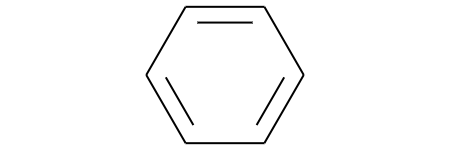

In [144]:
Chem.MolFromSmiles('C1=CC=CC=C1')

In [132]:
Mol = Chem.MolFromSmiles('[nH]1cccc1')

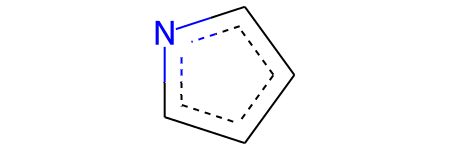

In [129]:
MolFromGraphsAro(env.stateSpaceGraph)

In [131]:
env.stateSpaceGraph.edata

{'type': tensor([[3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.]], device='cuda:0')}

In [133]:
g = (mol_to_graph(Mol))

In [141]:
g.ndata['atomic'] == env.stateSpaceGraph.ndata['atomic'].cpu()

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  

In [106]:
env.reset()
env.addAromaticRing_ccccn()

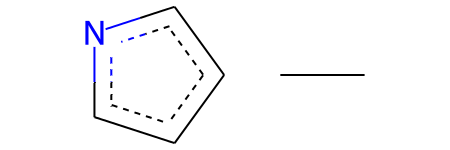

In [107]:
MolFromGraphsAro(env.stateSpaceGraph)